In [59]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import shutil
import csv
import numpy as np
import os
import matplotlib.pyplot as plt
import kwcoco, kwplot
import random
from pathlib import Path
from tqdm import tqdm

def show_img(img, dpi=150, title=None):
    fig, ax = plt.subplots(nrows=1, ncols=1, dpi=dpi)
    ax.set_title( title, fontsize=16, color='black')
    ax.axis('off')
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return fig, ax


def create_empty_dataset():
    return {"images":[], "categories":[], "annotations":[]}

image_dir  = Path('/media/HDD-4TB/__dataset__/Global_Wheat_Dataset_2021/gwhd_2021/images/')

metadata_csv_path  = Path('/media/HDD-4TB/__dataset__/Global_Wheat_Dataset_2021/gwhd_2021/metadata_dataset.csv')
train_csv_path     = Path('/media/HDD-4TB/__dataset__/Global_Wheat_Dataset_2021/gwhd_2021/competition_train.csv')
valid_csv_path     = Path('/media/HDD-4TB/__dataset__/Global_Wheat_Dataset_2021/gwhd_2021/competition_val.csv')
test_csv_path      = Path('/media/HDD-4TB/__dataset__/Global_Wheat_Dataset_2021/gwhd_2021/competition_test.csv')

# with open(metadata_csv_path, encoding='utf8', newline='') as f:
#     csvreader = csv.reader(f, delimiter=';')
#     for row in csvreader:
#         print(row)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
dataset_name = 'gwhd2021_coco'
output_dir = Path("./output/")

dataset_id = 1
supercategory = 'wheat_head'
category_name = 'wheat_head'
color = "#ffffff"

if not output_dir.exists():
    output_dir.mkdir(parents=True)

In [66]:

datasets = {
    'train': train_csv_path,
    'valid': valid_csv_path,
    'test' : test_csv_path,
}

for key in ["train", "valid", "test"]:
    
    img_root = output_dir / dataset_name / key
    coco_json_path = img_root / f"{key}.json"
    
    if not img_root.exists():
        os.makedirs(str(img_root), exist_ok=True)
    else:
        shutil.rmtree(str(img_root))
        os.makedirs(str(img_root), exist_ok=True)
        
    kw_dataset = kwcoco.CocoDataset(create_empty_dataset(), img_root=str(img_root))
    kw_dataset.img_root = str(img_root)
    
    category_id = kw_dataset.add_category(category_name, supercategory=supercategory, color=color)
    
    ## ------------------------------------- ##
    
    with open(datasets[key], encoding='utf8', newline='') as f:
        
        csvreader = csv.reader(f, delimiter=',')
        header = next(csvreader)
        
        for row in tqdm(csvreader, total=len([_ for _ in open(datasets[key], "rb")])-1):
            img_name = row[0]
            bboxes = [list(map(int, bbox.split(" "))) if bbox!="no_box" else None for bbox in row[1].split(';')]
            domain = row[2]
            
            # 画像のコピー
            img_path = image_dir / img_name
            if not img_path.exists():
                raise Exception(f"Image not found: {img_path}")
            shutil.copy(str(img_path), str(img_root))
            
            # 画像の追加
            img = cv2.imread(str(img_path))
            try:
                gid = kw_dataset.add_image(
                    img_name, 
                    dataset_id      = dataset_id,
                    category_ids    = [category_id],
                    width           = img.shape[1],
                    height          = img.shape[0],
                    num_annotations = len(bboxes),
                )
            except:
                print(img_path)
                continue
                

            # アノテーションの追加
            for bbox in bboxes:
                
                if bbox is None:
                    continue
                # bbox = [x_min, y_min, x_max, y_max]
                # print(bbox)
                
                new_bbox = [bbox[0], bbox[1], bbox[2]-bbox[0], bbox[3]-bbox[1]]
                aid = kw_dataset.add_annotation(
                    image_id      = gid,
                    category_id   = category_id,
                    dataset_id    = dataset_id,
                    iscrowd       = False,
                    isbbox        = True,
                    color         = color,
                    width         = img.shape[1],
                    height        = img.shape[0],
                    area          = new_bbox[-1]*new_bbox[-2],
                    bbox          = new_bbox,
                    creator       = "gwhd2021_coco.py",
                )
                
    
    ## ------------------------------------- ##
    
    with open(coco_json_path, 'w') as f:
        kw_dataset.dump(coco_json_path, indent=4, newlines=True)
        

  0%|          | 0/3657 [00:00<?, ?it/s]

 57%|█████▋    | 2086/3657 [00:29<00:09, 174.06it/s]

/media/HDD-4TB/__dataset__/Global_Wheat_Dataset_2021/gwhd_2021/images/d88963636d49127bda0597ef73f1703e92d6f111caefc44902d5932b8cd3fa94.png
/media/HDD-4TB/__dataset__/Global_Wheat_Dataset_2021/gwhd_2021/images/1961bcf453d5b2206c428c1c14fe55d1f26f3c655db0a2b6a83094476e8edb5b.png


 77%|███████▋  | 1066/1382 [00:08<00:02, 149.81it/s]

/media/HDD-4TB/__dataset__/Global_Wheat_Dataset_2021/gwhd_2021/images/da9846512ff19b8cd7278c8c973f75d36de8c4eb4e593b8285f6821aae1f4203.png


100%|██████████| 1382/1382 [00:10<00:00, 126.27it/s]


output/gwhd2021_coco/train/train.json
1721
output/gwhd2021_coco/valid/valid.json
493
output/gwhd2021_coco/test/test.json
203


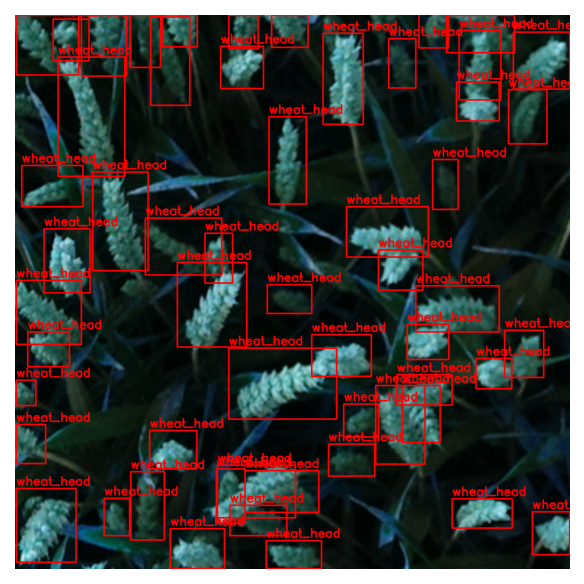

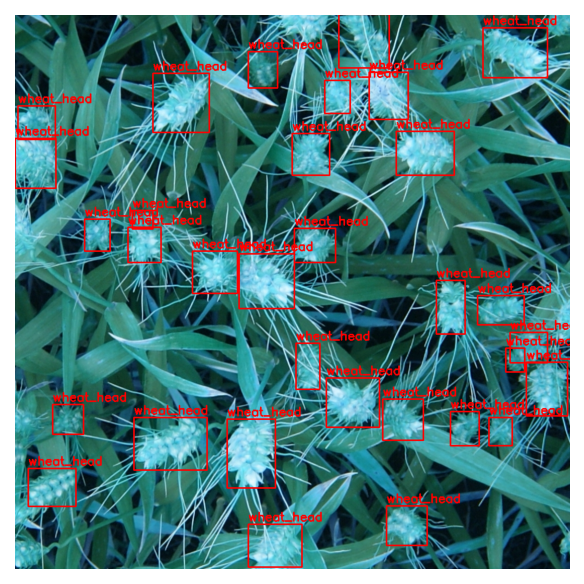

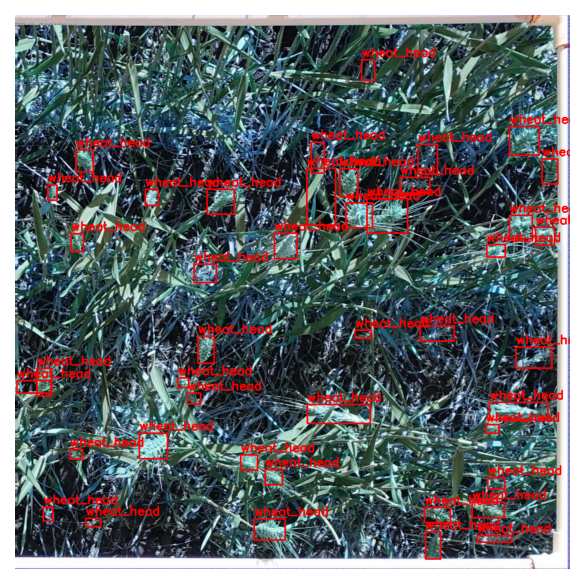

In [67]:
datasets = {
    'train': train_csv_path,
    'valid': valid_csv_path,
    'test' : test_csv_path,
}

for key in ["train", "valid", "test"]:
    
    img_root = output_dir / dataset_name / key
    coco_json_path = img_root / f"{key}.json"
    
    print(coco_json_path)
    kw_dataset = kwcoco.CocoDataset(coco_json_path, img_root=str(img_root))
    
    
    sample_imgId = random.choice(list(kw_dataset.imgs.keys()))
    print(sample_imgId)

    kwplot.autompl()
    visualized_image = kw_dataset.draw_image(gid=sample_imgId)

    show_img(visualized_image)